In [1]:
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy
!pip install gensim
!pip install seaborn
!pip install bokeh
!pip install pyldavis==2.1.2
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\RxN\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import os.path
import tweepy
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\RxN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Questions we are looking to answer about the Farmers Protest in India:
1) General sentiments of people - are they in favour of the Farm Bill or not - Classification. <br>
2) What are their main concerns - NER

## Set up config information

In [3]:
# CSV Names
RAW_CSV_NAME = "raw_tweets.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "hnGPJx6xBsudTgwOAxd0UNGUW"
CONSUMER_SECRET = "JcxhisQeF19hlEHRdeBifU3aL4R9DP9BWEMjYJ7MtnGcWaxn0p"
ACCESS_KEY = "1249286455530123264-5LbTPxHcE8Hl3CHhWztOsycMGEViHT"
ACCESS_SECRET = "4vdHhFP3odtZSUAKkK6GgPm7Vl03EHwvbP7cRTLFmQbFf"

pd.set_option('display.max_colwidth', -1)

<ipython-input-3-417303d6515a>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [4]:
USE_OLD_CSV = True

if not USE_OLD_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 5000
    result_type = "recent"
    lang = "en"
    # Do not include retweets, ensure tweet has 1 minimum retweet and is after September 2020        
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets min_retweets:1 since:2020-09-01",
                             result_type=result_type, lang=lang, tweet_mode="extended").items(max_items)

    # Extract only the required keys from the response
    tweets = [
        [tweet.created_at,
         tweet.full_text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified
        ] for tweet in response]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

## Preprocessing

In [12]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['text']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
print(processed_tweets_df['text_processed'].head())
processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

0    Proud moment for us congratulations ugraha ji and Tikat sir                                                                                                                                                       
1    UPDATE Bapu Sukhdev Singh ji has been released from jail Bapu Ji with our legal team Panjaab Lawyers Senior Advocate Paramjeet Singh Full video from todays release                                               
2    Found this one on Instragram page of SaffronStudios page                                                                                                                                                          
3    The country is proud of Punjabis The people who are still protesting against your stupid laws Had people protested during Demonetization /GST and all these 7 years we wouldnt have seen this India Bravo Punjabis
4    What a poetic message to Modi Gov                                                                                                  

 ## Word Cloud

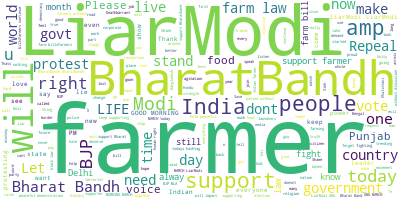

In [5]:
processed_tweets_df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

# Topic Modelling

In [6]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Do you want to modify this by adding more stop words?
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]


data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]


ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [8]:
from pprint import pprint

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"farmers" + 0.010*"protest" + 0.010*"india" + 0.010*"still" + '
  '0.010*"make" + 0.008*"support" + 0.008*"life" + 0.008*"rights" + '
  '0.008*"thank" + 0.006*"account"'),
 (1,
  '0.020*"farmers" + 0.013*"protest" + 0.009*"people" + 0.009*"bhagat" + '
  '0.009*"singh" + 0.009*"food" + 0.007*"like" + 0.007*"please" + 0.007*"amp" '
  '+ 0.007*"modi"'),
 (2,
  '0.029*"farmers" + 0.023*"india" + 0.013*"stand" + 0.011*"right" + '
  '0.011*"never" + 0.009*"bjp" + 0.009*"win" + 0.009*"still" + 0.007*"times" + '
  '0.007*"rights"'),
 (3,
  '0.014*"singh" + 0.013*"farmers" + 0.012*"bhagat" + 0.009*"protests" + '
  '0.009*"time" + 0.009*"raise" + 0.009*"never" + 0.008*"march" + '
  '0.007*"support" + 0.007*"speak"'),
 (4,
  '0.037*"farmers" + 0.027*"support" + 0.016*"bjp" + 0.015*"stand" + '
  '0.013*"good" + 0.009*"farmer" + 0.009*"see" + 0.008*"india" + '
  '0.008*"supporting" + 0.008*"boycott"')]


### What is the Dominant topic and its percentage contribution in each document

In [9]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5999,"farmers, protest, people, bhagat, singh, food, like, please, amp, modi",[investigation]
1,1,4.0,0.9199,"farmers, support, bjp, stand, good, farmer, see, india, supporting, boycott","[captain, saab, amarinder, need, investigate, police, officers, need, punished]"
2,2,2.0,0.8841,"farmers, india, stand, right, never, bjp, win, still, times, rights","[compromise, comes, injustice, fight, stand, farmers]"
3,3,0.0,0.8378,"farmers, protest, india, still, make, support, life, rights, thank, account","[farmers, india, fighting, livelihoods]"
4,4,0.0,0.7286,"farmers, protest, india, still, make, support, life, rights, thank, account","[farmers, farmers]"
5,5,4.0,0.7308,"farmers, support, bjp, stand, good, farmer, see, india, supporting, boycott","[covid, anyone]"
6,6,0.0,0.9110,"farmers, protest, india, still, make, support, life, rights, thank, account","[guys, follow, kro, ranjit, veere, de, account, nu]"
7,7,4.0,0.5998,"farmers, support, bjp, stand, good, farmer, see, india, supporting, boycott",[rss]
8,8,4.0,0.7293,"farmers, support, bjp, stand, good, farmer, see, india, supporting, boycott","[stand, farmers]"
9,9,1.0,0.8386,"farmers, protest, people, bhagat, singh, food, like, please, amp, modi","[everyone, please, read, share]"


### The most representative sentence for each topic

In [10]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9464,"farmers, protest, india, still, make, support, life, rights, thank, account","[godaddy, launches, new, marketing, campaign, ms, dhoni, inspire, local, businesses, india, busi..."
1,1.0,0.9376,"farmers, protest, people, bhagat, singh, food, like, please, amp, modi","[kisan, ekta, zindabadtake, back, black, farm, lawskeep, supporting, indian, farmersno, farmers,..."
2,2.0,0.9499,"farmers, india, stand, right, never, bjp, win, still, times, rights","[bas, evm, ban, ho, jaye, ta, sab, leaders, fair, treeke, naal, hi, choose, hon, ge]"
3,3.0,0.9331,"singh, farmers, bhagat, protests, time, raise, never, march, support, speak","[long, go, without, internet, phone, sleeping, time, wont, count, honest, lol]"
4,4.0,0.9329,"farmers, support, bjp, stand, good, farmer, see, india, supporting, boycott","[bail, granted, mohinder, singh, ji, khalsamandeep, singhakashpreet, singhjust, brothers, inside..."


### Frequency Distribution of Word Counts in Documents

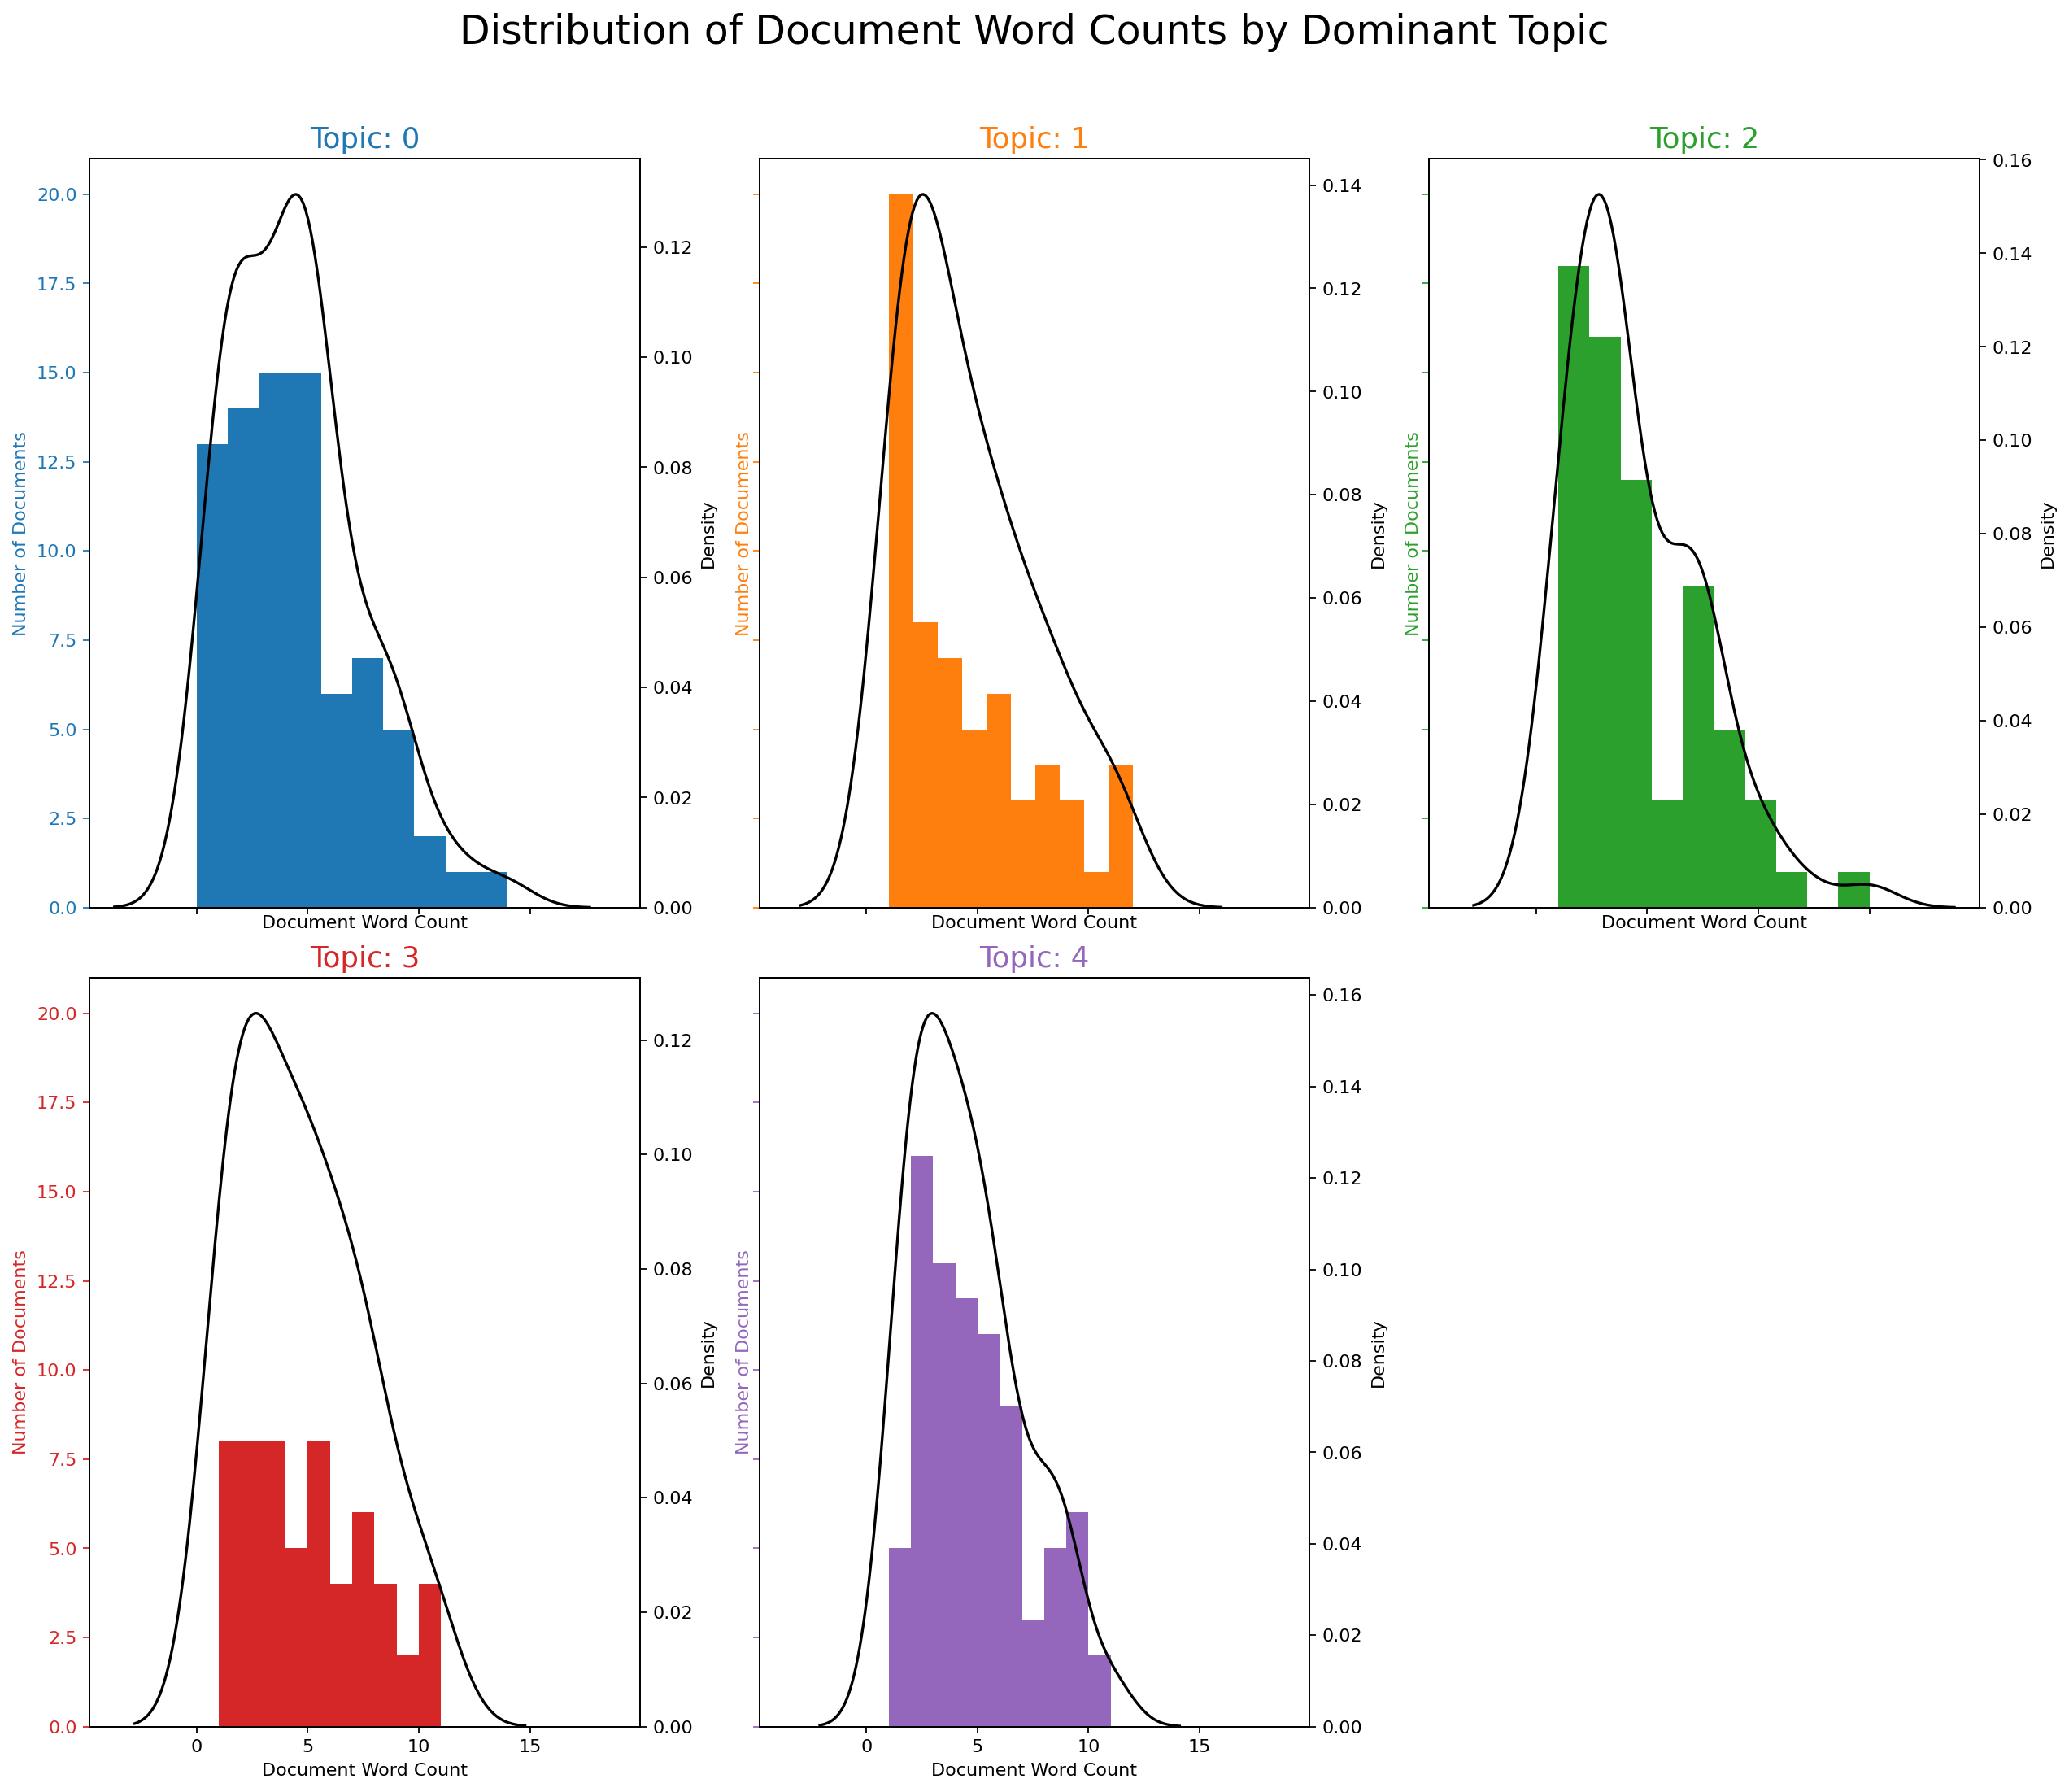

In [11]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):  
    if i<num_topics:
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
    else:
        ax.set_visible(False)

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

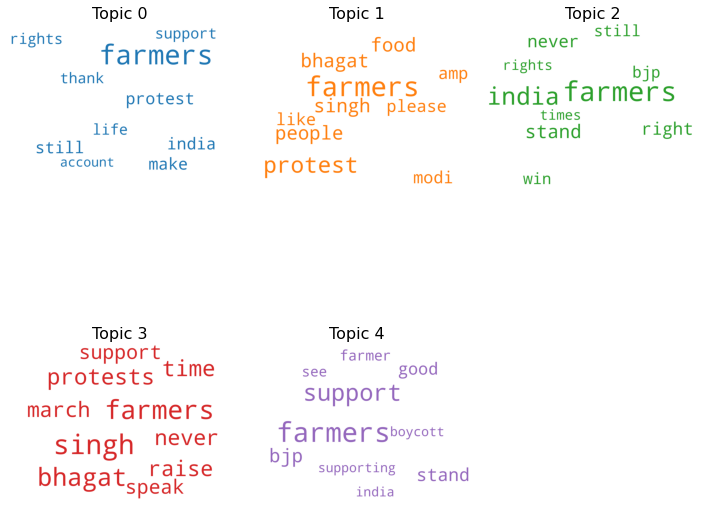

In [12]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i<len(topics):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    else:
        ax.set_visible(False)


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

<ipython-input-13-5db36dac2dd8>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-13-5db36dac2dd8>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-13-5db36dac2dd8>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-13-5db36dac2dd8>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


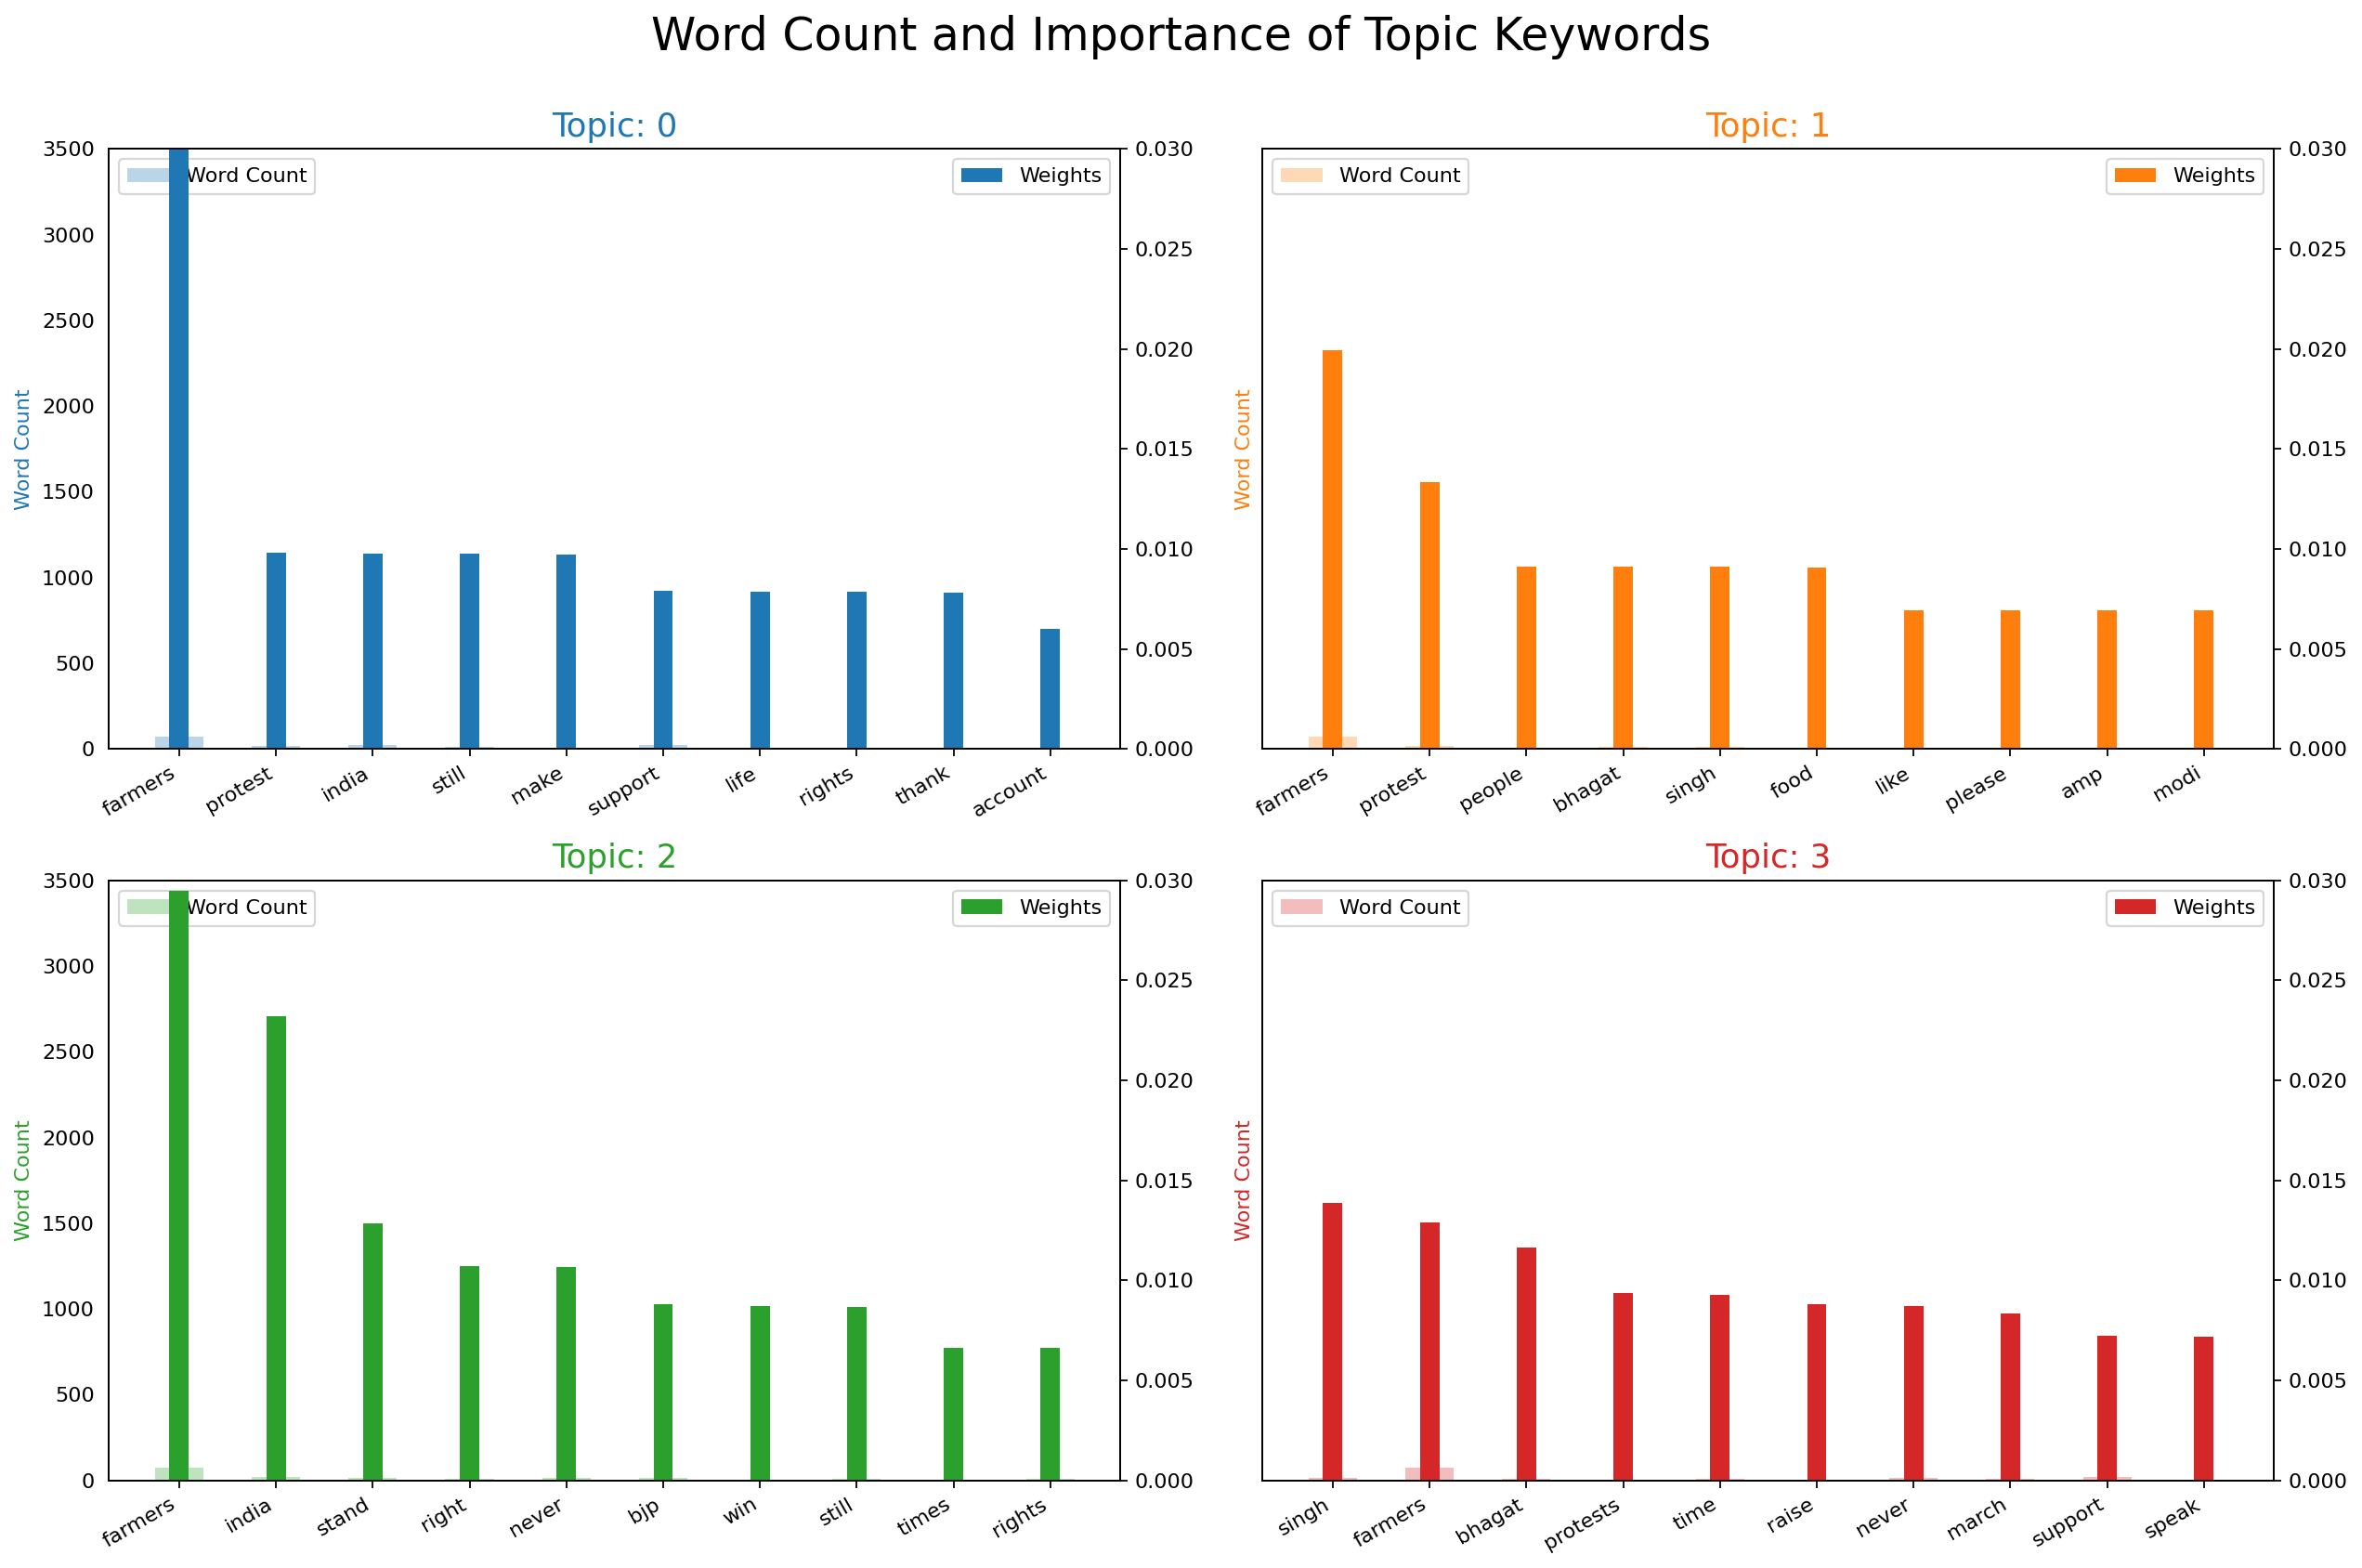

In [13]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    if i<len(topics):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    else:
        ax.set_visible(False)
        

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### t-distributed stochastic neighbor embedding Clustering Chart

In [14]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 345 samples in 0.001s...
[t-SNE] Computed neighbors for 345 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 345 / 345
[t-SNE] Mean sigma: 0.046106
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.069084
[t-SNE] KL divergence after 1000 iterations: 0.046133


Loading BokehJS ...

In [15]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./topic-modelled-'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './topic-modelled-'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.081008 -0.004333       1        1  22.828221
0     -0.078402 -0.037674       2        1  22.005184
2     -0.001110  0.115774       3        1  19.322669
1      0.113289  0.004660       4        1  18.295570
3      0.047231 -0.078427       5        1  17.548356, topic_info=         Term       Freq      Total Category  logprob  loglift
47    support  14.000000  14.000000  Default  30.0000  30.0000
14      stand   9.000000   9.000000  Default  29.0000  29.0000
134      good   5.000000   5.000000  Default  28.0000  28.0000
16      india  14.000000  14.000000  Default  27.0000  27.0000
139    bhagat   6.000000   6.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
201     today   1.061427   2.514481   Topic5  -5.5609   0.8778
62        win   1.342393   4.397735   Topic5  -5.3261   0.5536
11    farmers   3.561940  47.360216   Topic5  -4.3502  -0.8473
47    support   1.999221  14.794096   Topic5  -4.9278  -0.2613
238  remember   1.373602   5.054217   Topic5  -5.3031   0.4374

[292 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
20        1  0.309484       account
20        2  0.618967       account
807       5  0.797219        affect
806       5  0.533398         agree
110       4  0.793546        albert
...     ...       ...           ...
279       1  0.312412         world
279       2  0.312412         world
279       5  0.312412         world
761       2  0.778463         worst
723       4  0.793545  zindabadtake

[370 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 2, 4])

## Sentiment Analysis

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


            created_at  \
0  2021-03-22 23:16:07   
1  2021-03-22 23:14:39   
2  2021-03-22 23:14:12   
3  2021-03-22 23:12:51   
4  2021-03-22 22:55:32   

                                                                                                  text  \
0          Can we have an investigation on this @SukhpalKhaira #FarmersProtest https://t.co/qe5ttozzPE   
1  Captain Saab @capt_amarinder You need to investigate this. Police officers need to be punished. ...   
2  There is no compromise when it comes to injustice. You have to fight it.Stand with our farmers\n...   
3  Farmers in India are fighting for their livelihoods. 🙏✊🏼\n#IStandWithFarmers\n#FarmersProtest ht...   
4                   #23march with farmers #23March_किसानों_के_साथ #FarmersProtest #BoycottBJP_4Farmers   

   retweet_count  favorite_count user_screen_name  user_followers_count  \
0              0               0   LyllpuriaDeep1                   905   
1              0               0   LyllpuriaDeep1       

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.convert_xunits(self.ax_index).astype(np.int)


<AxesSubplot:title={'center':'sentiment analysis'}>

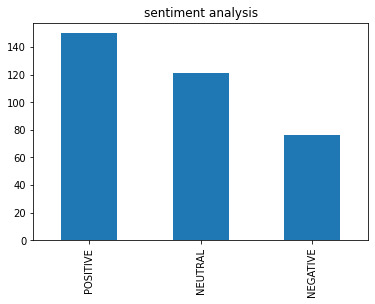

In [16]:
df = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')

sid = SentimentIntensityAnalyzer()

df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

print(df.head())
df.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")

## Named Entity Recognition

In [17]:
import spacy
import en_core_web_trf

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     |████████████████████████████████| 459.7 MB 11 kB/s  eta 0:00:011  |▎                               | 3.7 MB 163 kB/s eta 0:46:34     |██▍                             | 34.1 MB 4.0 MB/s eta 0:01:48     |█████▊                          | 82.4 MB 4.8 MB/s eta 0:01:18     |██████▎                         | 90.2 MB 3.9 MB/s eta 0:01:36     |███████▍                        | 106.9 MB 3.6 MB/s eta 0:01:40     |█████████▊                      | 140.4 MB 4.8 MB/s eta 0:01:07     |██████████▊                     | 154.0 MB 3.2 MB/s eta 0:01:36     |████████████▍                   | 177.4 MB 3.6 MB/s eta 0:01:20     |███████████████▎                | 219.6 MB 3.6 MB/s eta 0:01:08     |████████████████                | 231.0 MB 4.5 MB/s eta 0:00:51     |████████████████▏               | 232.8 MB 4.5 MB/s eta 0:00:50     |█████████████████▍              | 249.8 MB 4.6 MB/s eta 0:00:46     |███████████████████▎            | 276.7 MB 3.2 MB/s eta 0:00:57     |██████████████████████▊         | 3

In [18]:
nlp = spacy.load('en_core_web_sm')
unique_tweets = pd.read_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8')
unique_tweets_list = list(unique_tweets['text_processed'].values)

print(unique_tweets_list)

entities = list()

for tweet_text in unique_tweets_list:
  doc = nlp(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, ne.text,"--",tweet_text)
    entities.append(ne.text)

print(entities)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['can we have an investigation on this', 'captain saab amarinder you need to investigate this police officers need to be punished', 'there is no compromise when it comes to injustice you have to fight it stand with our farmers', 'farmers in india are fighting for their livelihoods', 'with farmers 4farmers', 'what about covid 19 anyone', 'guys follow kro ranjit veere de account nu', 'no to rss', 'we stand with farmers', 'everyone please read and share', 'are you kidding me', 'salute to great martyrs and farmers jai kisan', 'they are all fake', 'honour our martyrs', 'his legacy continues', 'save agriculture support farmer protest', 'respect farmer support farmersprotest', 'its time to correct this grave mistake', 'bollywood starts who lost my respect', 'india stand against crony capitalism', 'day 117death toll 300', 'farmers will win', 'i have a feel the creator isnt too kind to genocidal narcissists', 'for my dearest andhbhakt', 'never forgot our martyrs', 'now days andhbakhts are getti